In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("recommendation/train.csv").drop(['timestamp'], 1)
test = pd.read_csv("recommendation/test.csv")
movies = pd.read_csv("recommendation/movies.csv")
imdb = pd.read_csv("recommendation/imdb_data.csv")
genome_scores = pd.read_csv("recommendation/genome_scores.csv")
sample = pd.read_csv("recommendation/sample_submission.csv")

In [3]:
train.shape, test.shape, sample.shape, movies.shape, imdb.shape, genome_scores.shape

((10000038, 3),
 (5000019, 2),
 (5000019, 2),
 (62423, 3),
 (27278, 6),
 (15584448, 3))

In [4]:
train.describe()

,userId,movieId,rating
count,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00
std,4.679359e+04,3.919578e+04,1.061124e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,4.051000e+04,1.197000e+03,3.000000e+00
50%,8.091400e+04,2.947000e+03,3.500000e+00
75%,1.215790e+05,8.630000e+03,4.000000e+00
max,1.625410e+05,2.091710e+05,5.000000e+00


In [5]:
imdb.describe()

,movieId,runtime
count,27278.000000,15189.000000
mean,59855.480570,100.312331
std,44429.314697,31.061707
min,1.000000,1.000000
25%,6931.250000,89.000000
50%,68068.000000,98.000000
75%,100293.250000,109.000000
max,131262.000000,877.000000


In [6]:
genome_scores.describe()

,movieId,tagId,relevance
count,1.558445e+07,1.558445e+07,1.558445e+07
mean,4.602249e+04,5.645000e+02,1.163679e-01
std,5.535221e+04,3.256254e+02,1.544722e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,3.853750e+03,2.827500e+02,2.400000e-02
50%,8.575500e+03,5.645000e+02,5.650000e-02
75%,8.018650e+04,8.462500e+02,1.407500e-01
max,2.064990e+05,1.128000e+03,1.000000e+00


In [7]:
imdb

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
...,...,...,...,...,...,...
27273,131254,Franz Dinda|Florian Lukas|Axel Stein|Kailas Ma...,Carsten Funke,85.0,NaN,man wrapped in a towel|man wears a thong|male ...
27274,131256,Rick Kavanian|Axel Stein|Eva Habermann|Christo...,Matthias Dinter,83.0,"DEM5,800,000",ski|ski resort|ampersand in title|drink in title
27275,131258,Nam-gil Kim|Ye-jin Son|Hae-Jin Yoo|Kyeong-yeon...,Seong-il Cheon,130.0,NaN,pirate|sword fight|korea|bandit
27276,131260,Martti Suosalo|Ilkka Koivula|Vexi Salmi|Riitta...,Timo Koivusalo,102.0,NaN,friend|friendship|television show|restaurant


In [8]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [9]:
movies['release_year'] = movies['title'].str[-5:-1]
movies['genres'] = movies['genres'].str.split('|')
imdb['title_cast'] = imdb['title_cast'].str.split('|')
imdb['plot_keywords'] = imdb['plot_keywords'].str.split('|')

In [10]:
df = pd.merge(train, movies, on='movieId')
data = df.merge(imdb, on='movieId')
data

,userId,movieId,rating,title,genres,release_year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
1,87388,57669,3.5,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
2,137050,57669,4.0,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
3,120490,57669,4.5,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
4,50616,57669,4.5,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
...,...,...,...,...,...,...,...,...,...,...,...
9633026,129077,66579,3.0,"Lost, The (2009)",[Thriller],2009,"[Armand Assante, Dina Meyer, Lacey Chabert, Se...",Dan Dworkin,95.0,NaN,NaN
9633027,78784,96316,3.5,Aliisa (1970),[Drama],1970,"[Siiri Angerkoski, Selma Miettinen, Varma Laht...",Aulikki Oksanen,NaN,NaN,"[janitor, income, housing problem, social prob..."
9633028,80974,82732,3.0,New York Confidential (1955),"[Crime, Drama, Film-Noir]",1955,NaN,NaN,NaN,NaN,NaN
9633029,84146,107912,3.0,"Fallen, The (2004)","[Action, Drama, War]",2004,"[Christopher R Swanson, Daniel Asher, Brian Ba...",Nick Day,112.0,"$600,000","[soldier, italy, partisan, fascist]"


In [11]:
data.groupby('director')['rating'].mean().sort_values(ascending=False)

director
Robert W. Allan    5.0
Till Schauder      5.0
Paul Osborne       5.0
Valarie Trapp      5.0
T Bone Burnett     5.0
                  ... 
Siegfried          0.5
James Bird         0.5
Spike Brandt       0.5
Andrea Grano       0.5
50 Cent            0.5
Name: rating, Length: 9995, dtype: float64

In [12]:
data.groupby('title')['rating'].mean().sort_values(ascending=False)

title
Wrestling for Jesus: The Tale of T-Money (2011)       5.0
The... Beautiful Country (1977)                       5.0
Only Daughter (2013)                                  5.0
Vasermil (2007)                                       5.0
Day the Universe Changed, The (1985)                  5.0
                                                     ... 
Time to Kill (Tempo di uccidere) (1989)               0.5
Dangerous Place, A (2012)                             0.5
Dana Carvey: Squatting Monkeys Tell No Lies (2008)    0.5
I Love, You Love (Ja milujem, ty milujes) (1989)      0.5
Beautiful Girl (2014)                                 0.5
Name: rating, Length: 23534, dtype: float64

In [13]:
#data['counts'] = pd.DataFrame(data.groupby('title')['budget'].count())

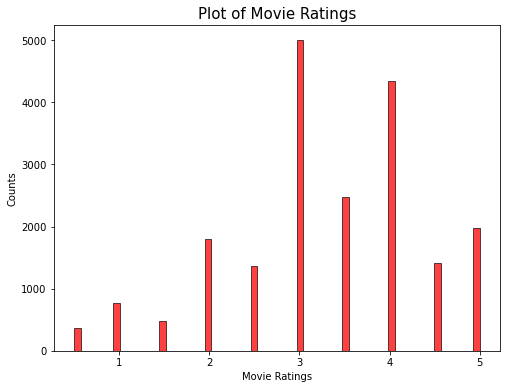

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(data['rating'][:20000], color='red')

#sns.countplot(y=train['rating'], data=train, order=train['rating'].value_counts().head().index)
plt.xlabel('Movie Ratings')
plt.ylabel('Counts')
plt.title('Plot of Movie Ratings', fontsize=15)
plt.show()

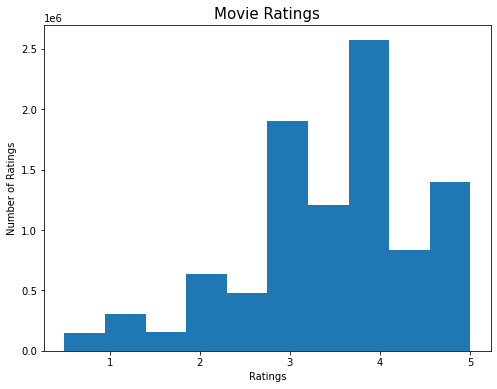

In [15]:
plt.figure(figsize=(8, 6))
data['rating'].hist()

plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.title('Movie Ratings', fontsize=15)
plt.grid(False)
plt.show()

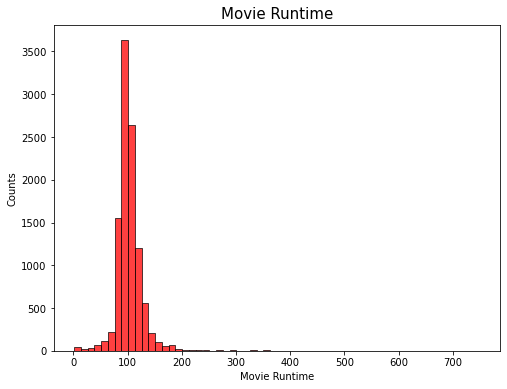

In [16]:
plt.figure(figsize=(8, 6))
#data['runtime'][:20000].plot(kind='barh')
sns.histplot(imdb['runtime'][:20000], bins=60, color='red')
plt.xlabel('Movie Runtime')
plt.ylabel('Counts')
plt.title('Movie Runtime', fontsize=15)
plt.show()

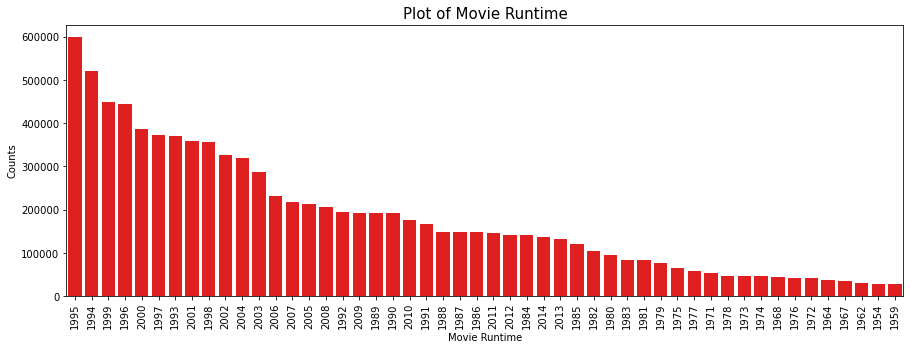

In [17]:
plt.figure(figsize=(15, 5))
sns.countplot(x=data['release_year'], order=data['release_year'].value_counts()[0:50].index, color='red')
plt.xlabel('Movie Runtime')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Plot of Movie Runtime', fontsize=15)
plt.show()

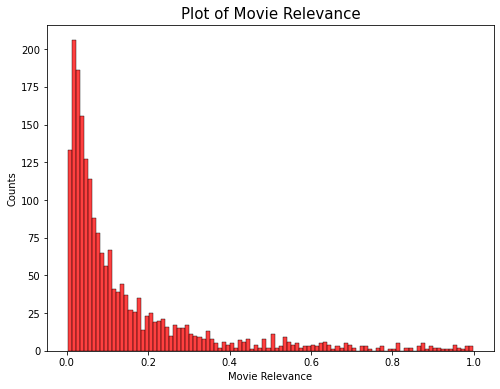

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(genome_scores['relevance'][:2000], bins=100, color='red')
plt.xlabel('Movie Relevance')
plt.ylabel('Counts')
plt.title('Plot of Movie Relevance', fontsize=15)
plt.show()

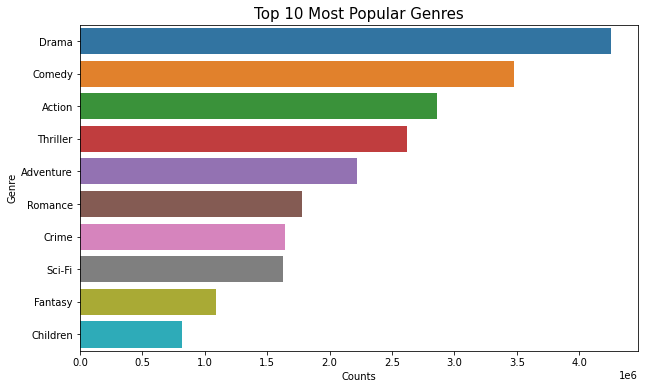

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(y=data['genres'].explode(), order=data['genres'].explode().value_counts().index[:10])
plt.ylabel('Genre')
plt.xlabel('Counts')
plt.title('Top 10 Most Popular Genres', fontsize=15)
plt.yticks(rotation=0)
plt.show()

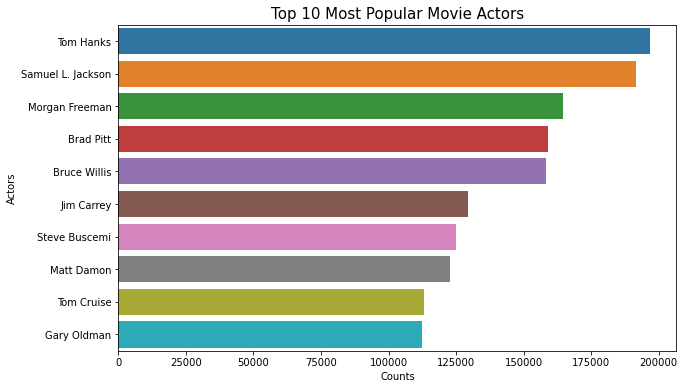

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(y=data['title_cast'].explode(), order=data['title_cast'].explode().value_counts().index[:10])
plt.ylabel('Actors')
plt.xlabel('Counts')
plt.title('Top 10 Most Popular Movie Actors', fontsize=15)
plt.yticks(rotation=0)
plt.show()

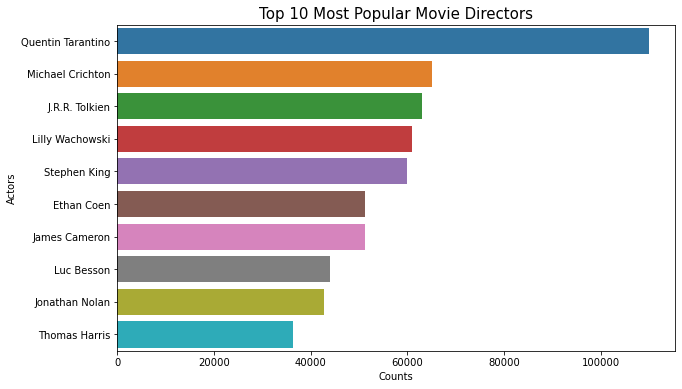

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(y=data['director'].explode(), order=data['director'].explode().value_counts().index[:10])
plt.ylabel('Actors')
plt.xlabel('Counts')
plt.title('Top 10 Most Popular Movie Directors', fontsize=15)
plt.yticks(rotation=0)
plt.show()

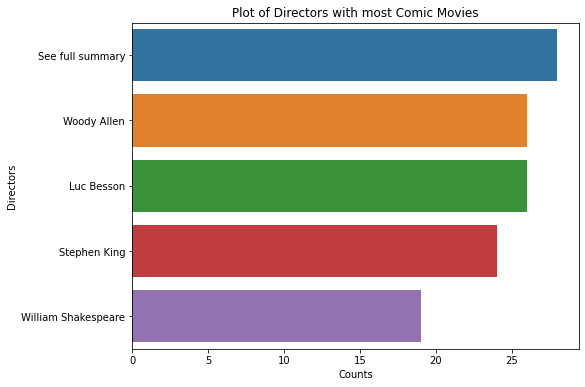

In [22]:
plt.figure(figsize=(8, 6))
top_movies = data[data['genres']=='Comedy']
sns.countplot(y='director', data=imdb, order=imdb['director'].value_counts().head().index)

plt.ylabel('Directors')
plt.xlabel('Counts')
plt.title('Plot of Directors with most Comic Movies')
plt.show()

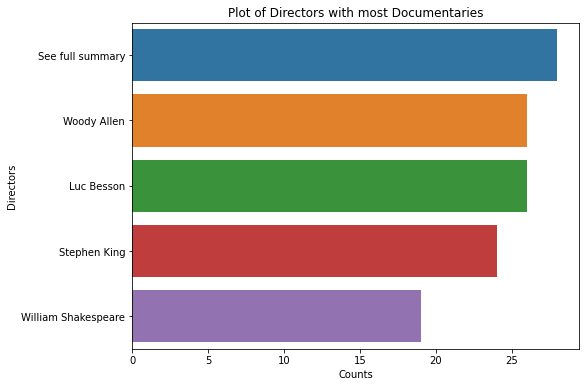

In [23]:
plt.figure(figsize=(8, 6))
top_movies = data[data['genres']=='Documentary']
sns.countplot(y='director', data=imdb, order=imdb['director'].value_counts().head().index)

plt.ylabel('Directors')
plt.xlabel('Counts')
plt.title('Plot of Directors with most Documentaries')
plt.show()

In [24]:
def wordcloud(data):
    wcloud = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords.words('english')).generate(str(data))
    plt.figure(figsize=(12, 10))
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

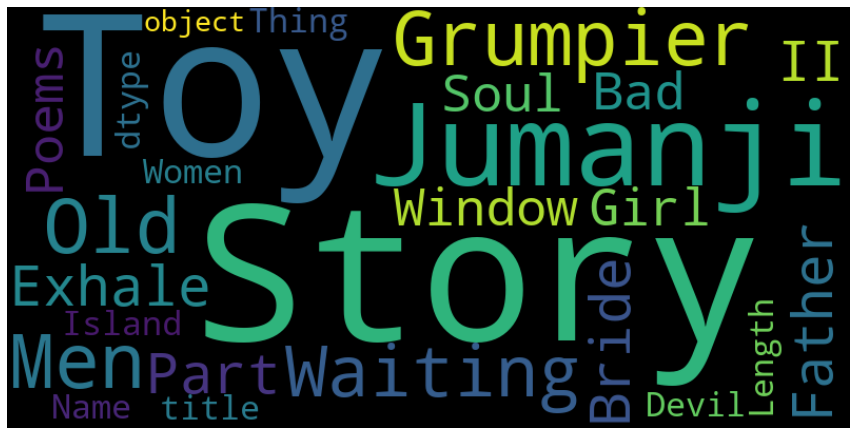

In [25]:
wordcloud(movies['title'])

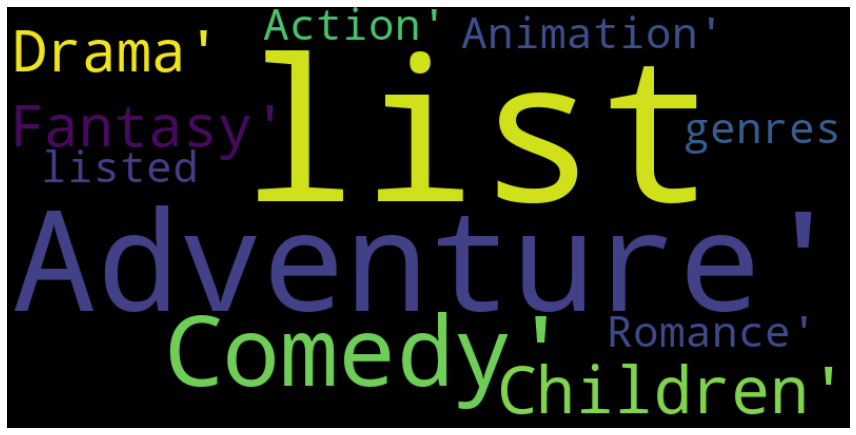

In [26]:
wordcloud(movies['genres'].values)

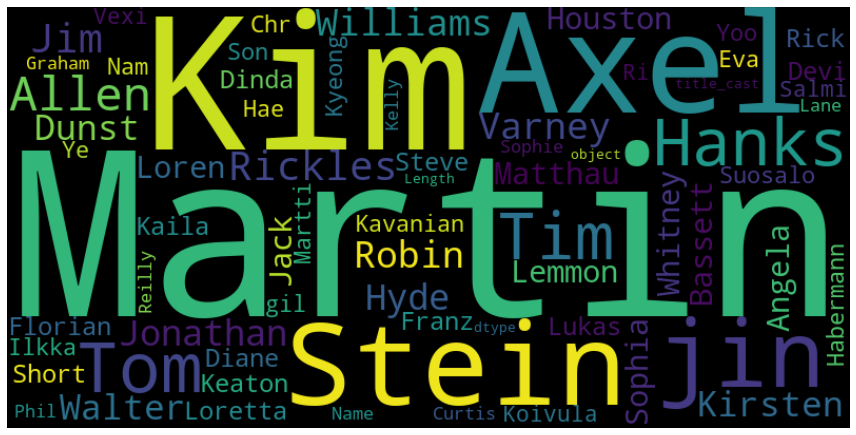

In [27]:
wordcloud(imdb['title_cast'])

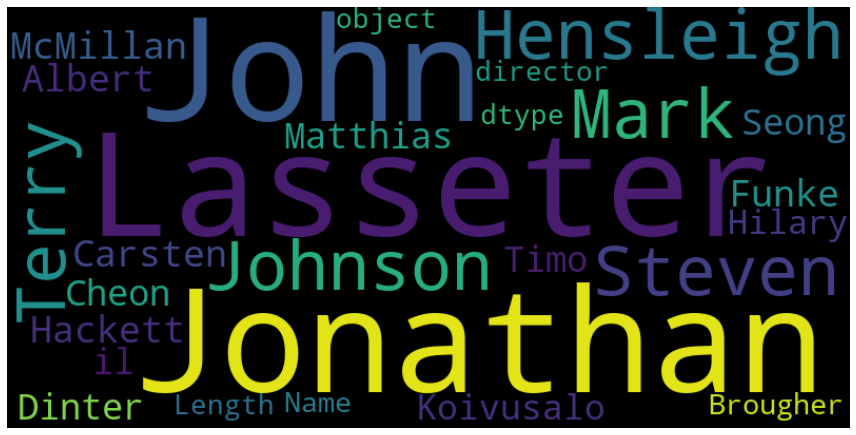

In [28]:
wordcloud(imdb['director'])

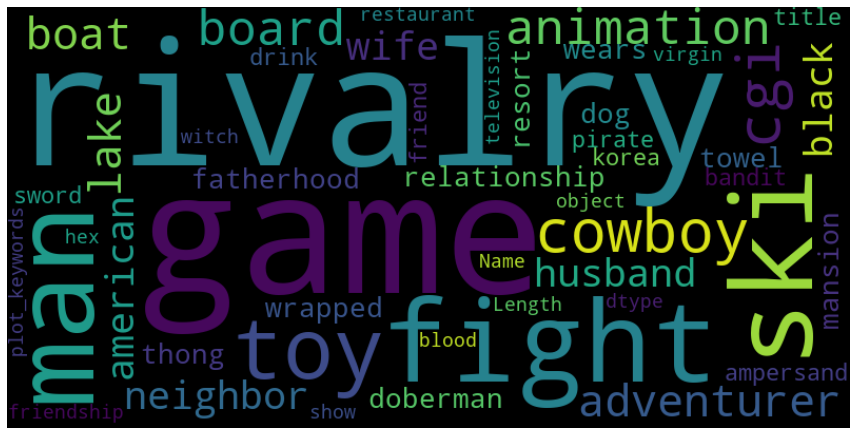

In [29]:
wordcloud(imdb['plot_keywords'])

In [30]:
X = data[['userId', 'movieId', 'rating']][:1000000].drop(['rating'], axis=1)
y = data['rating'][:1000000]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [32]:
X_train = StandardScaler().fit_transform(X_train)

In [33]:
svr = SVR()
linear = LinearRegression()
forest= RandomForestRegressor(n_estimators=200, random_state=11)
neighbors = KNeighborsRegressor()
boost = AdaBoostRegressor(n_estimators=200, random_state=11)
extra = ExtraTreesRegressor(random_state=11)
gradboo = GradientBoostingRegressor(random_state=11)

In [34]:
linear.fit(X_train, y_train)

LinearRegression()

In [35]:
lin_pred = linear.predict(X_test)
lin_rmse = np.sqrt(metrics.mean_squared_error(y_test, lin_pred))
lin_rmse 

130.74035803919168

In [36]:
%%time

neigh = neighbors.fit(X_train, y_train)
neighbor_pred = neigh.predict(X_test)
neighbor_rmse = np.sqrt(metrics.mean_squared_error(y_test, neighbor_pred))
neighbor_rmse

CPU times: total: 3.84 s
Wall time: 3.97 s


1.1105888978375391

In [37]:
%%time

xtratree = extra.fit(X_train, y_train)
xtratree_pred = xtratree.predict(X_test)
xtratree_rmse = np.sqrt(metrics.mean_squared_error(y_test, xtratree_pred))
xtratree_rmse

CPU times: total: 3min 54s
Wall time: 4min 21s


1.2691619839484636

In [38]:
%%time

gradboost = gradboo.fit(X_train, y_train)
gradboost_pred = gradboost.predict(X_test)
gradboost_rmse = np.sqrt(metrics.mean_squared_error(y_test, gradboost_pred))
gradboost_rmse

CPU times: total: 2min 9s
Wall time: 2min 21s


1.0823881728954918

In [41]:
"""%%time

frest = forest.fit(X_train, y_train)
forest_pred = frest.predict(X_test)
forest_rmse = np.sqrt(metrics.mean_squared_error(y_test, forest_pred))
forest_rmse"""

'%%time\n\nfrest = forest.fit(X_train, y_train)\nforest_pred = frest.predict(X_test)\nforest_rmse = np.sqrt(metrics.mean_squared_error(y_test, forest_pred))\nforest_rmse'

NameError: name 'forest_rmse' is not defined

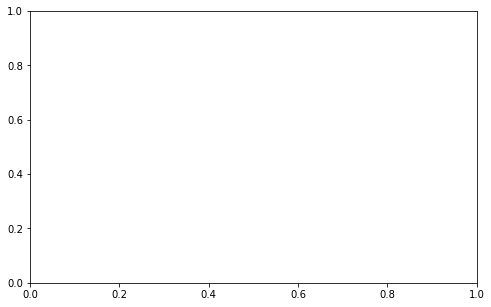

In [40]:
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['RandomForest', 'KNearestNeighbor', 'GradientBoost', 'ExtraTree']
rmse_y = [forest_rmse, neighbor_rmse, gradboost_rmse, xtratree_rmse]

ax = sns.barplot(x=rmse_x, y=rmse_y, edgecolor='black')
plt.title("RMSE Values over Collaborative-Based Filtering", fontsize=14)
plt.xticks(rotation=90)
plt.ylabel("RMSE")

plt.show()

In [ ]:
test = StandardScaler().fit_transform(test)

In [ ]:
test_pred = gradboost.predict(test)
test_pred

In [ ]:
submission = pd.DataFrame({'id':sample['Id'], 'rating':test_pred})
submission.head()

In [ ]:
submission.to_csv('Unsuper_Predict_Submission', index=False)

In [ ]:
"""%%time

boosting = boost.fit(X_train, y_train)
boosting_pred = boosting.predict(X_test)
boosting_rmse = np.sqrt(metrics.mean_squared_error(y_test, boosting_pred))
boosting_rmse"""

In [ ]:
"""%%time

sve = svr.fit(X_train, y_train)
svr_pred = sve.predict(X_test)
svr_rmse = np.sqrt(metrics.mean_squared_error(y_test, svr_pred))
svr_rmse"""

    
#rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

In [ ]:
"""tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
data['plot_keywords'] = data['plot_keywords'].fillna('')
tfi_matrix = tfidf.fit_transform(data['plot_keywords'])
tfi_matrix.shape
"""
# takes longer time to run ~1.5mins

In [ ]:
"""indices = pd.Series(dara.index, index=dara['title']).drop_duplicates()

def recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1].any(), reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    
    return dara['title'].iloc[movie_indices]"""

In [ ]:
"""! pip install numpy
! pip install scikit-surprise"""

In [ ]:
! pip install geopandas